# 물체 감지


이 Colab은 물체 감지를 수행하도록 훈련된 TF-Hub 모듈의 사용 예를 보여줍니다.

## 설정


In [1]:
%config InlineBackend.figure_format = 'retina'

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.13.0-rc1
The following GPU devices are available: 


## 사용 예

### 이미지 다운로드 및 시각화를 위한 도우미 함수

가장 간단한 필수 기능을 제공하도록 [TF 물체 감지 API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)에서 조정된 시각화 코드입니다.

In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## 모듈 적용하기

Open Images v4에서 공개 이미지를 로드하고 로컬에 저장한 다음 표시합니다.

/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/tmpgwsex1fo.jpg.


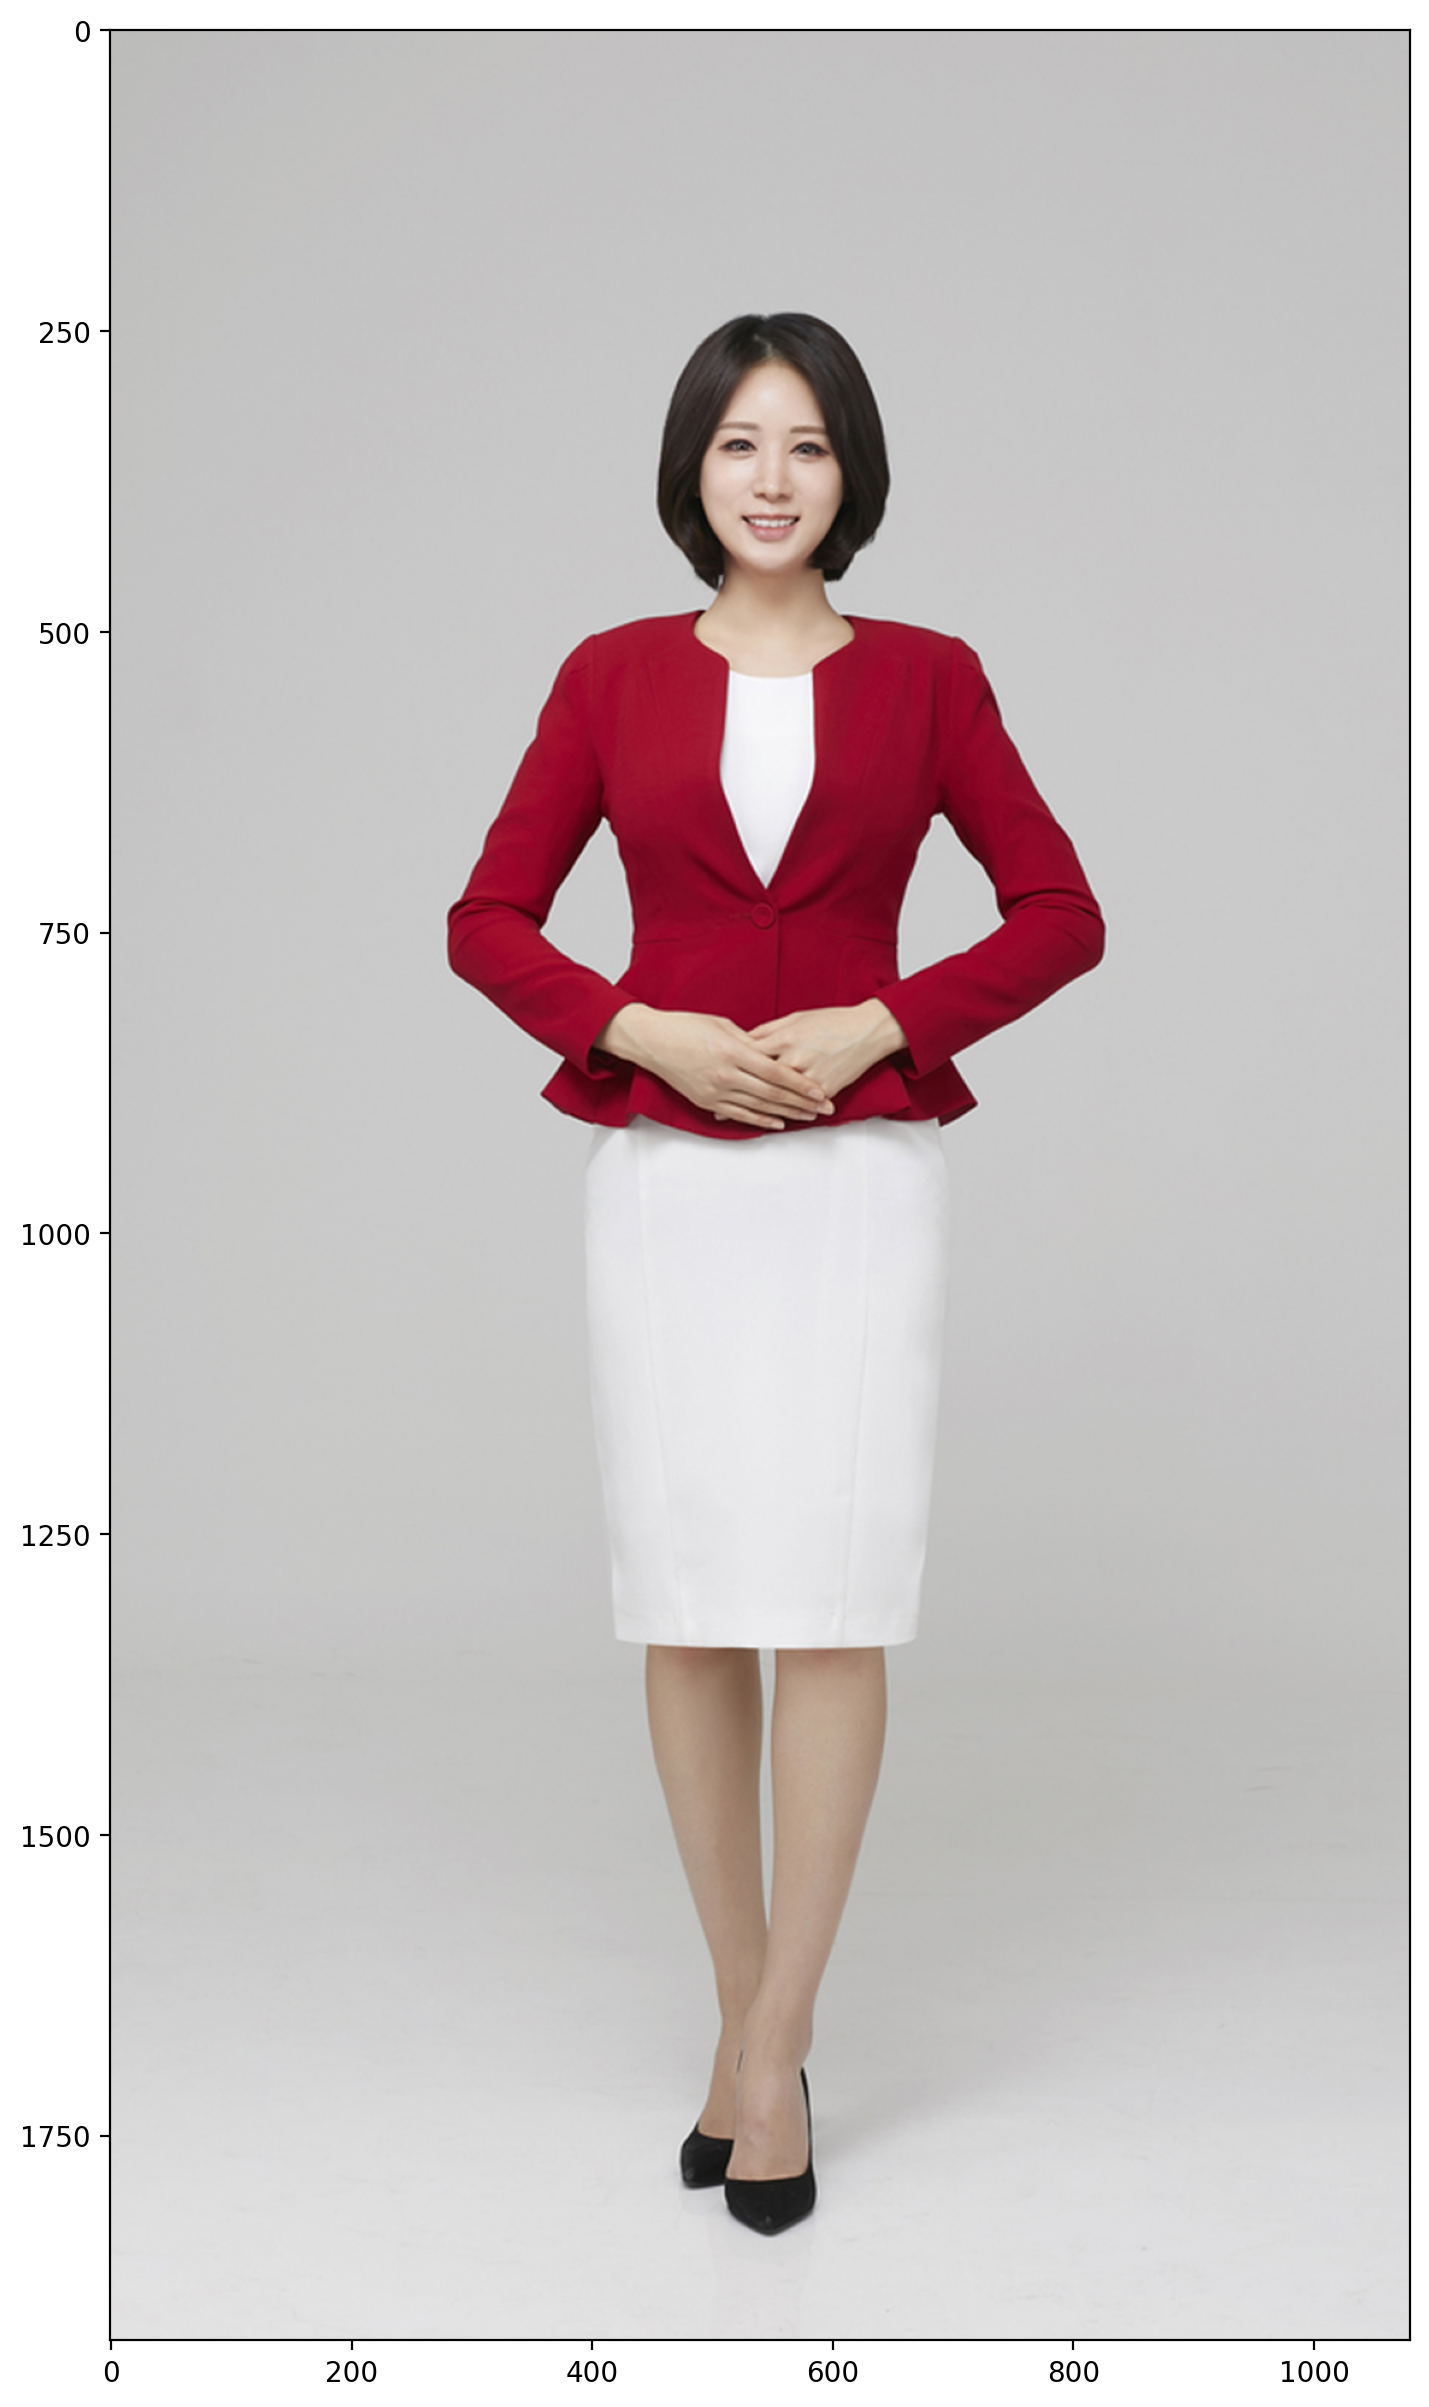

In [3]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "http://gangnamstar.co.kr/files/attach/images/466/518/027/f1195f13cacc2a21f68ec8b01fba3d0d.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1080, 1920, True)

물체 감지 모듈을 선택하고 다운로드한 이미지에 적용합니다. 모듈:

- **FasterRCNN+InceptionResNet V2**: 높은 정확성
- **ssd + mobilenet V2**: 작고 빠름

In [12]:
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"                 # SSD + MobileNet v2
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  # Faster R-CNN + Inception ResNet v2

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [14]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

2023-06-22 22:17:11.257005: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 17 } dim { size: 17 }

Found 100 objects.
Inference time:  22.14596199989319
Font not found, using default font.


/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


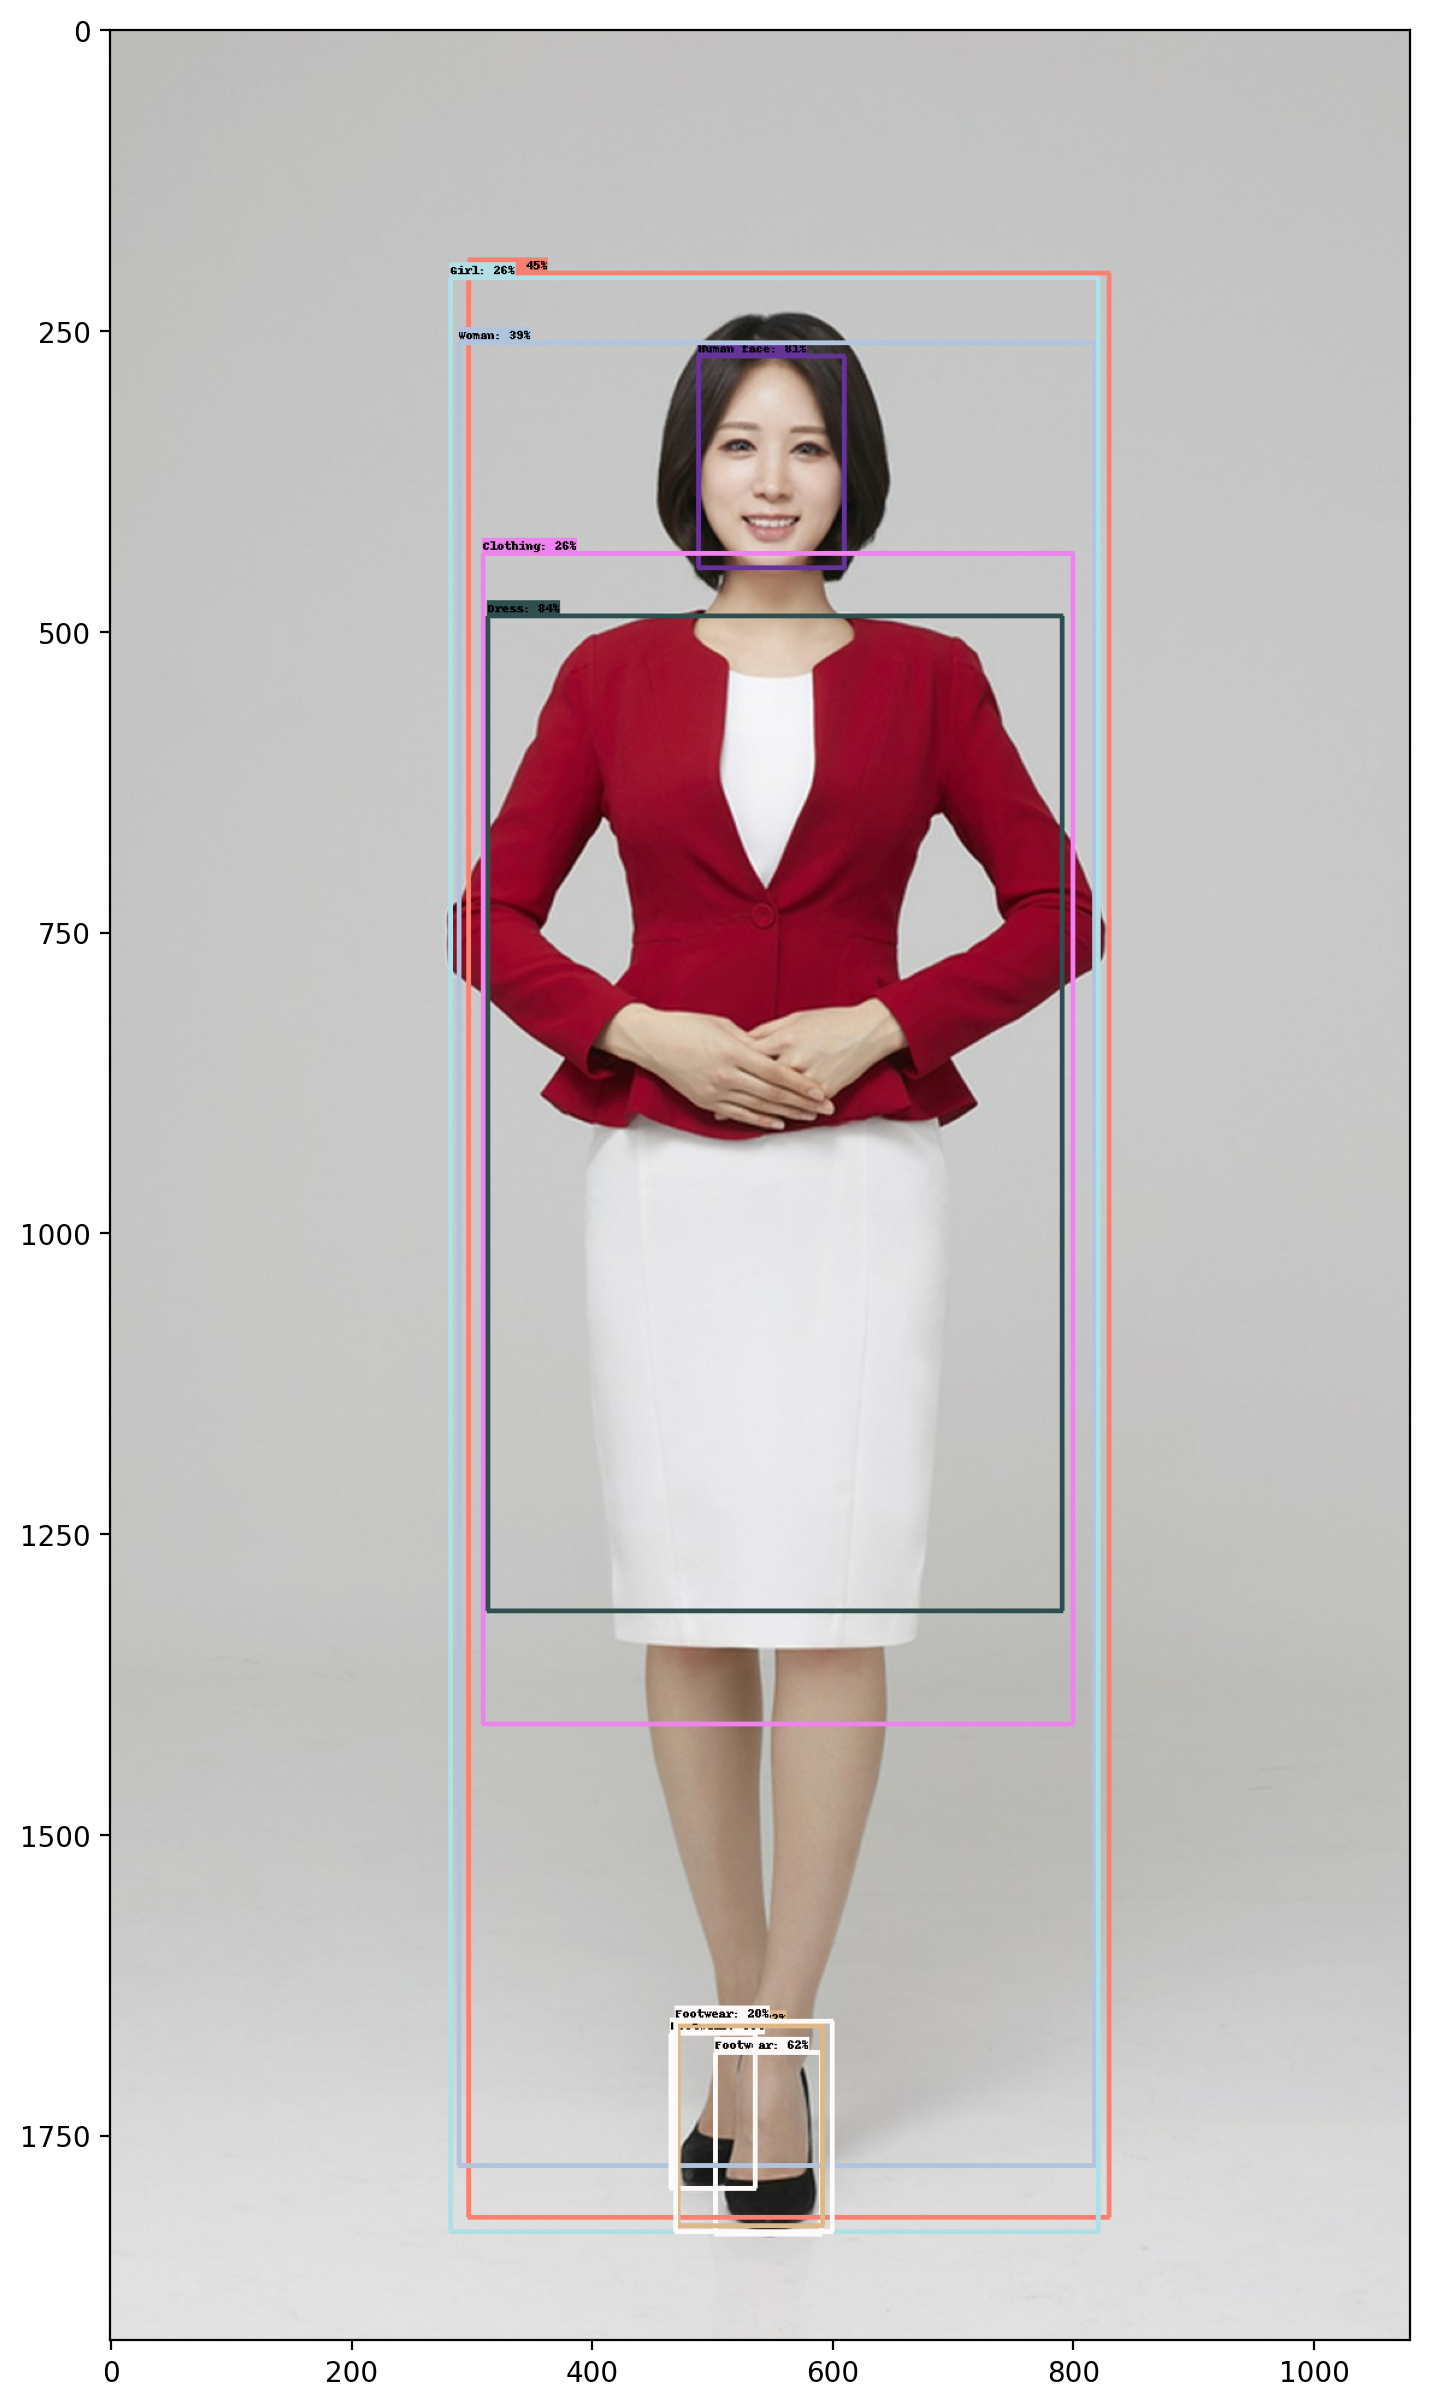

In [15]:
run_detector(detector, downloaded_image_path)

### 더 많은 이미지

시간 추적을 사용하여 일부 추가 이미지에 추론을 수행합니다.


In [8]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Image downloaded to /var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/tmpgdahdez_.jpg.
Found 100 objects.
Inference time:  0.0505070686340332
Font not found, using default font.
Inference time: 0.9584000110626221


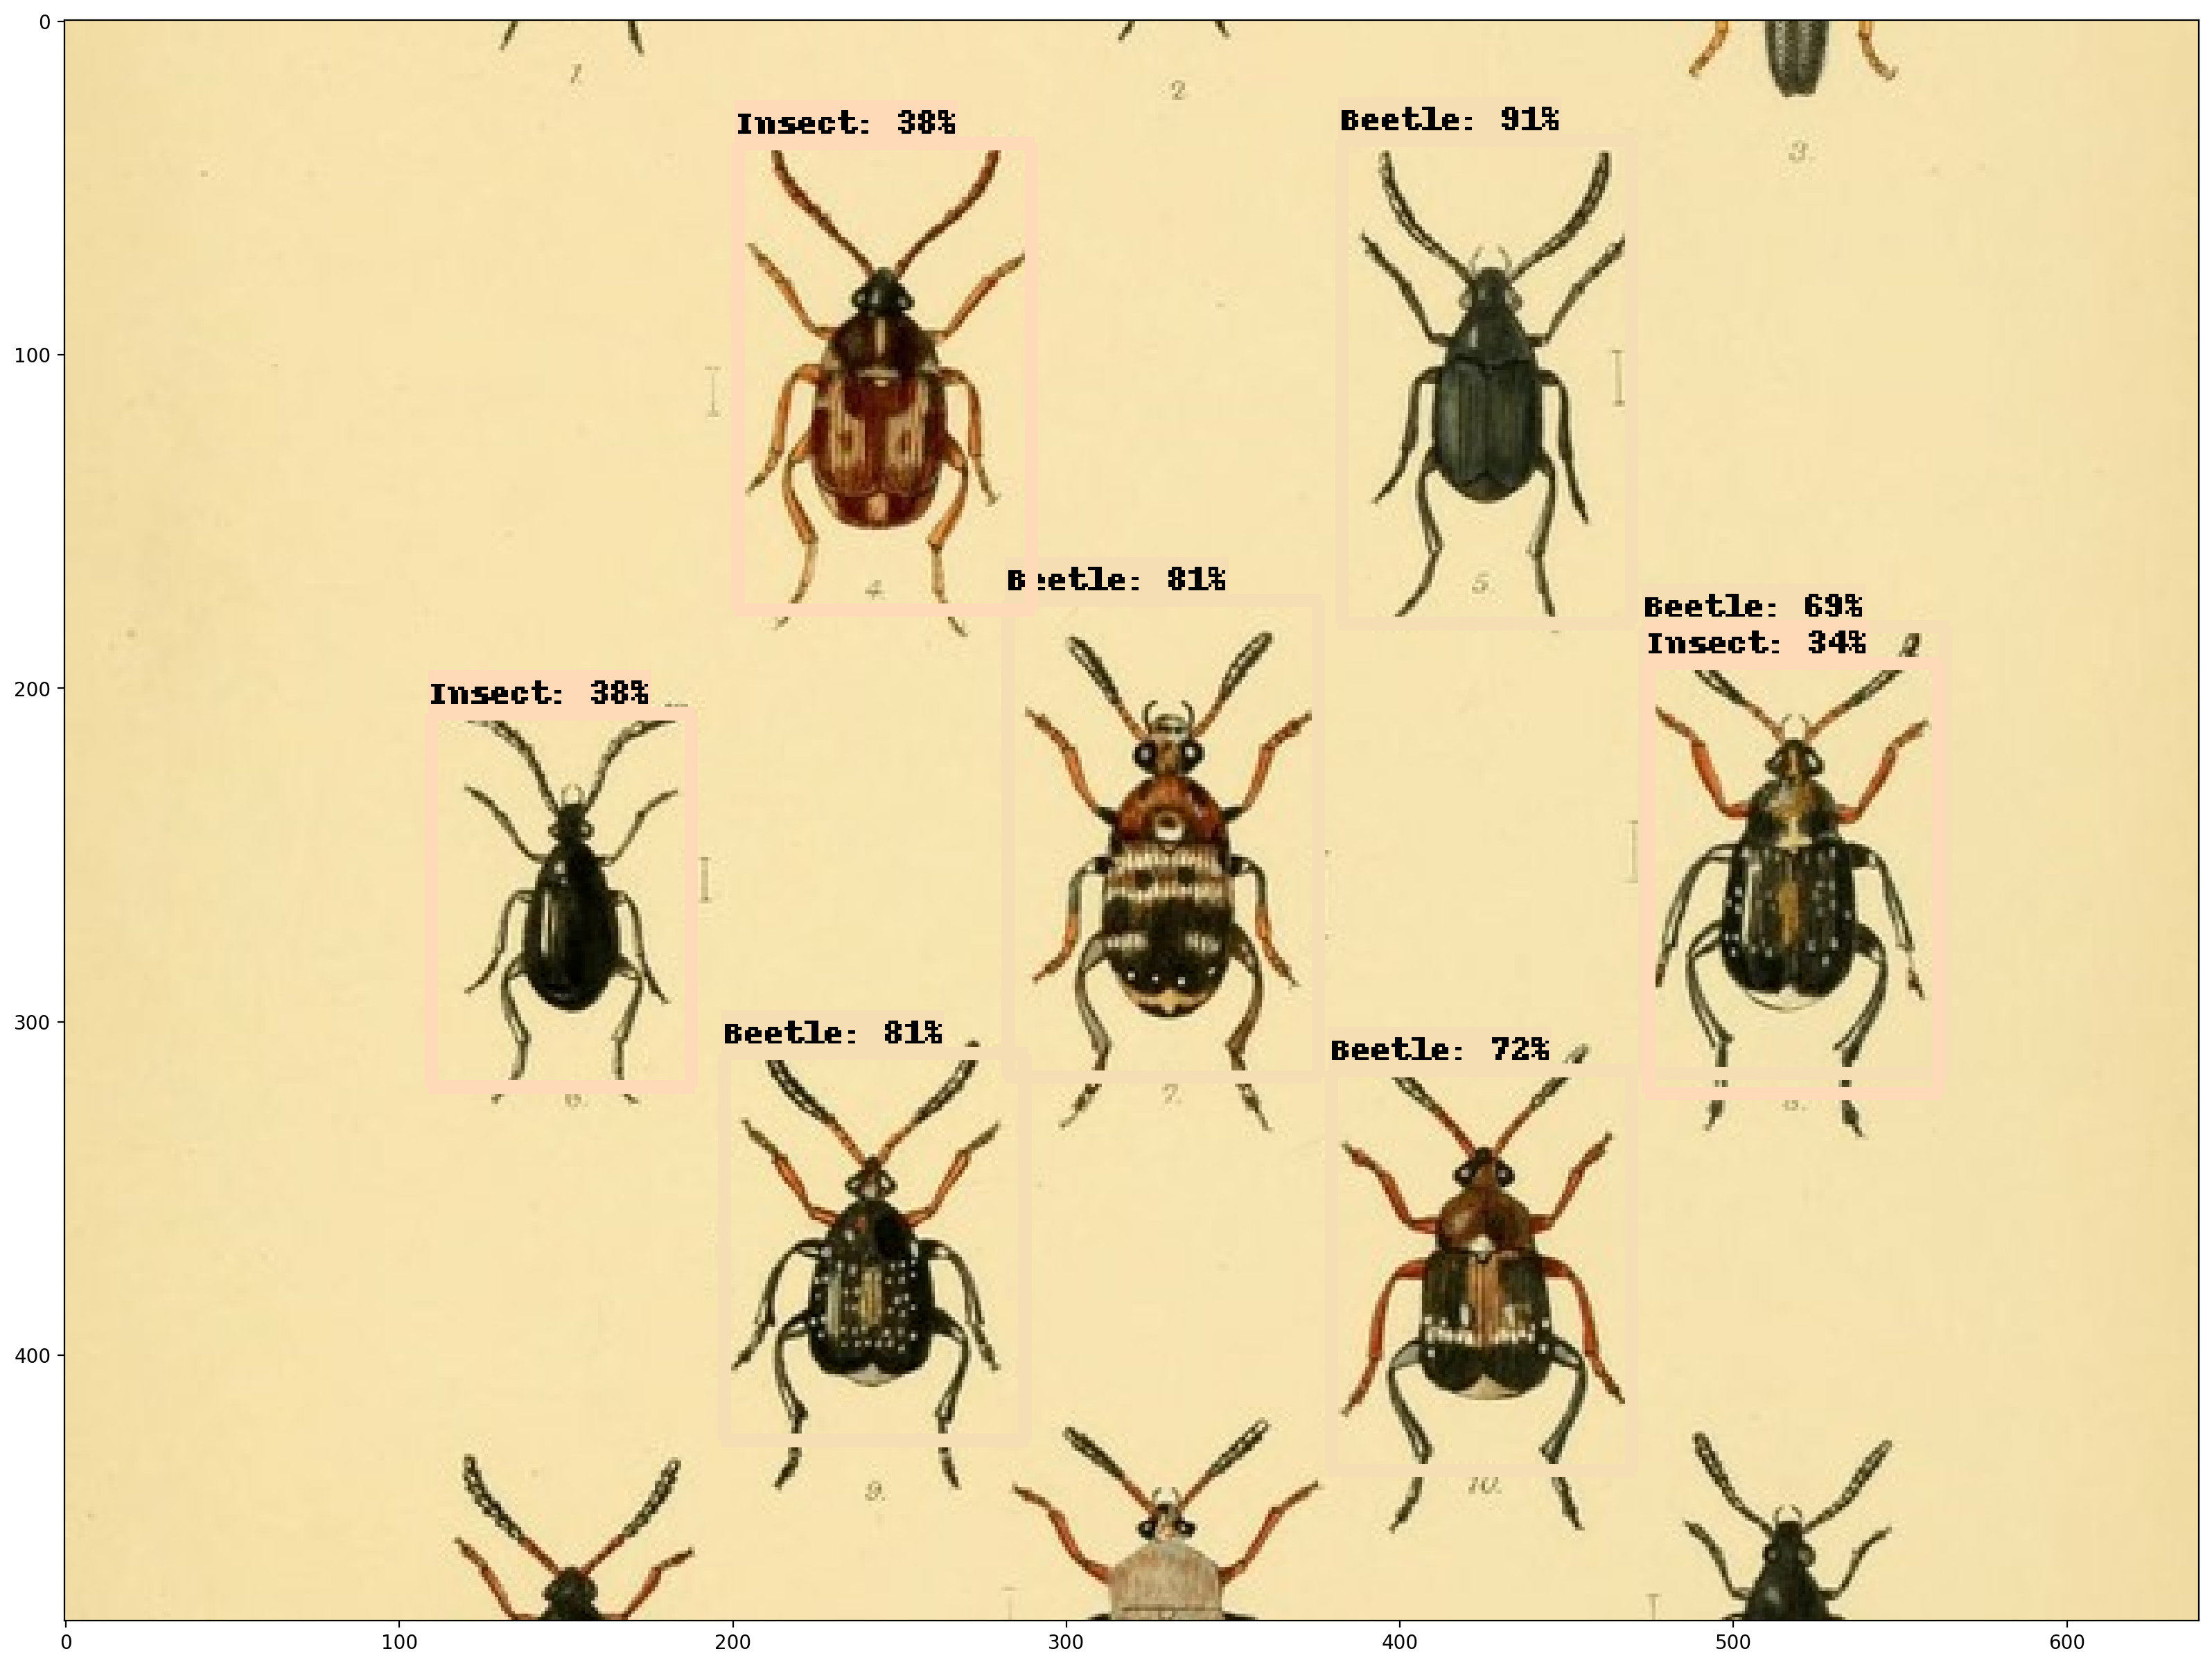

In [9]:
detect_img(image_urls[0])

/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Image downloaded to /var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/tmpa3xkv4ak.jpg.
Found 100 objects.
Inference time:  0.0461728572845459
Font not found, using default font.
Inference time: 0.649461030960083


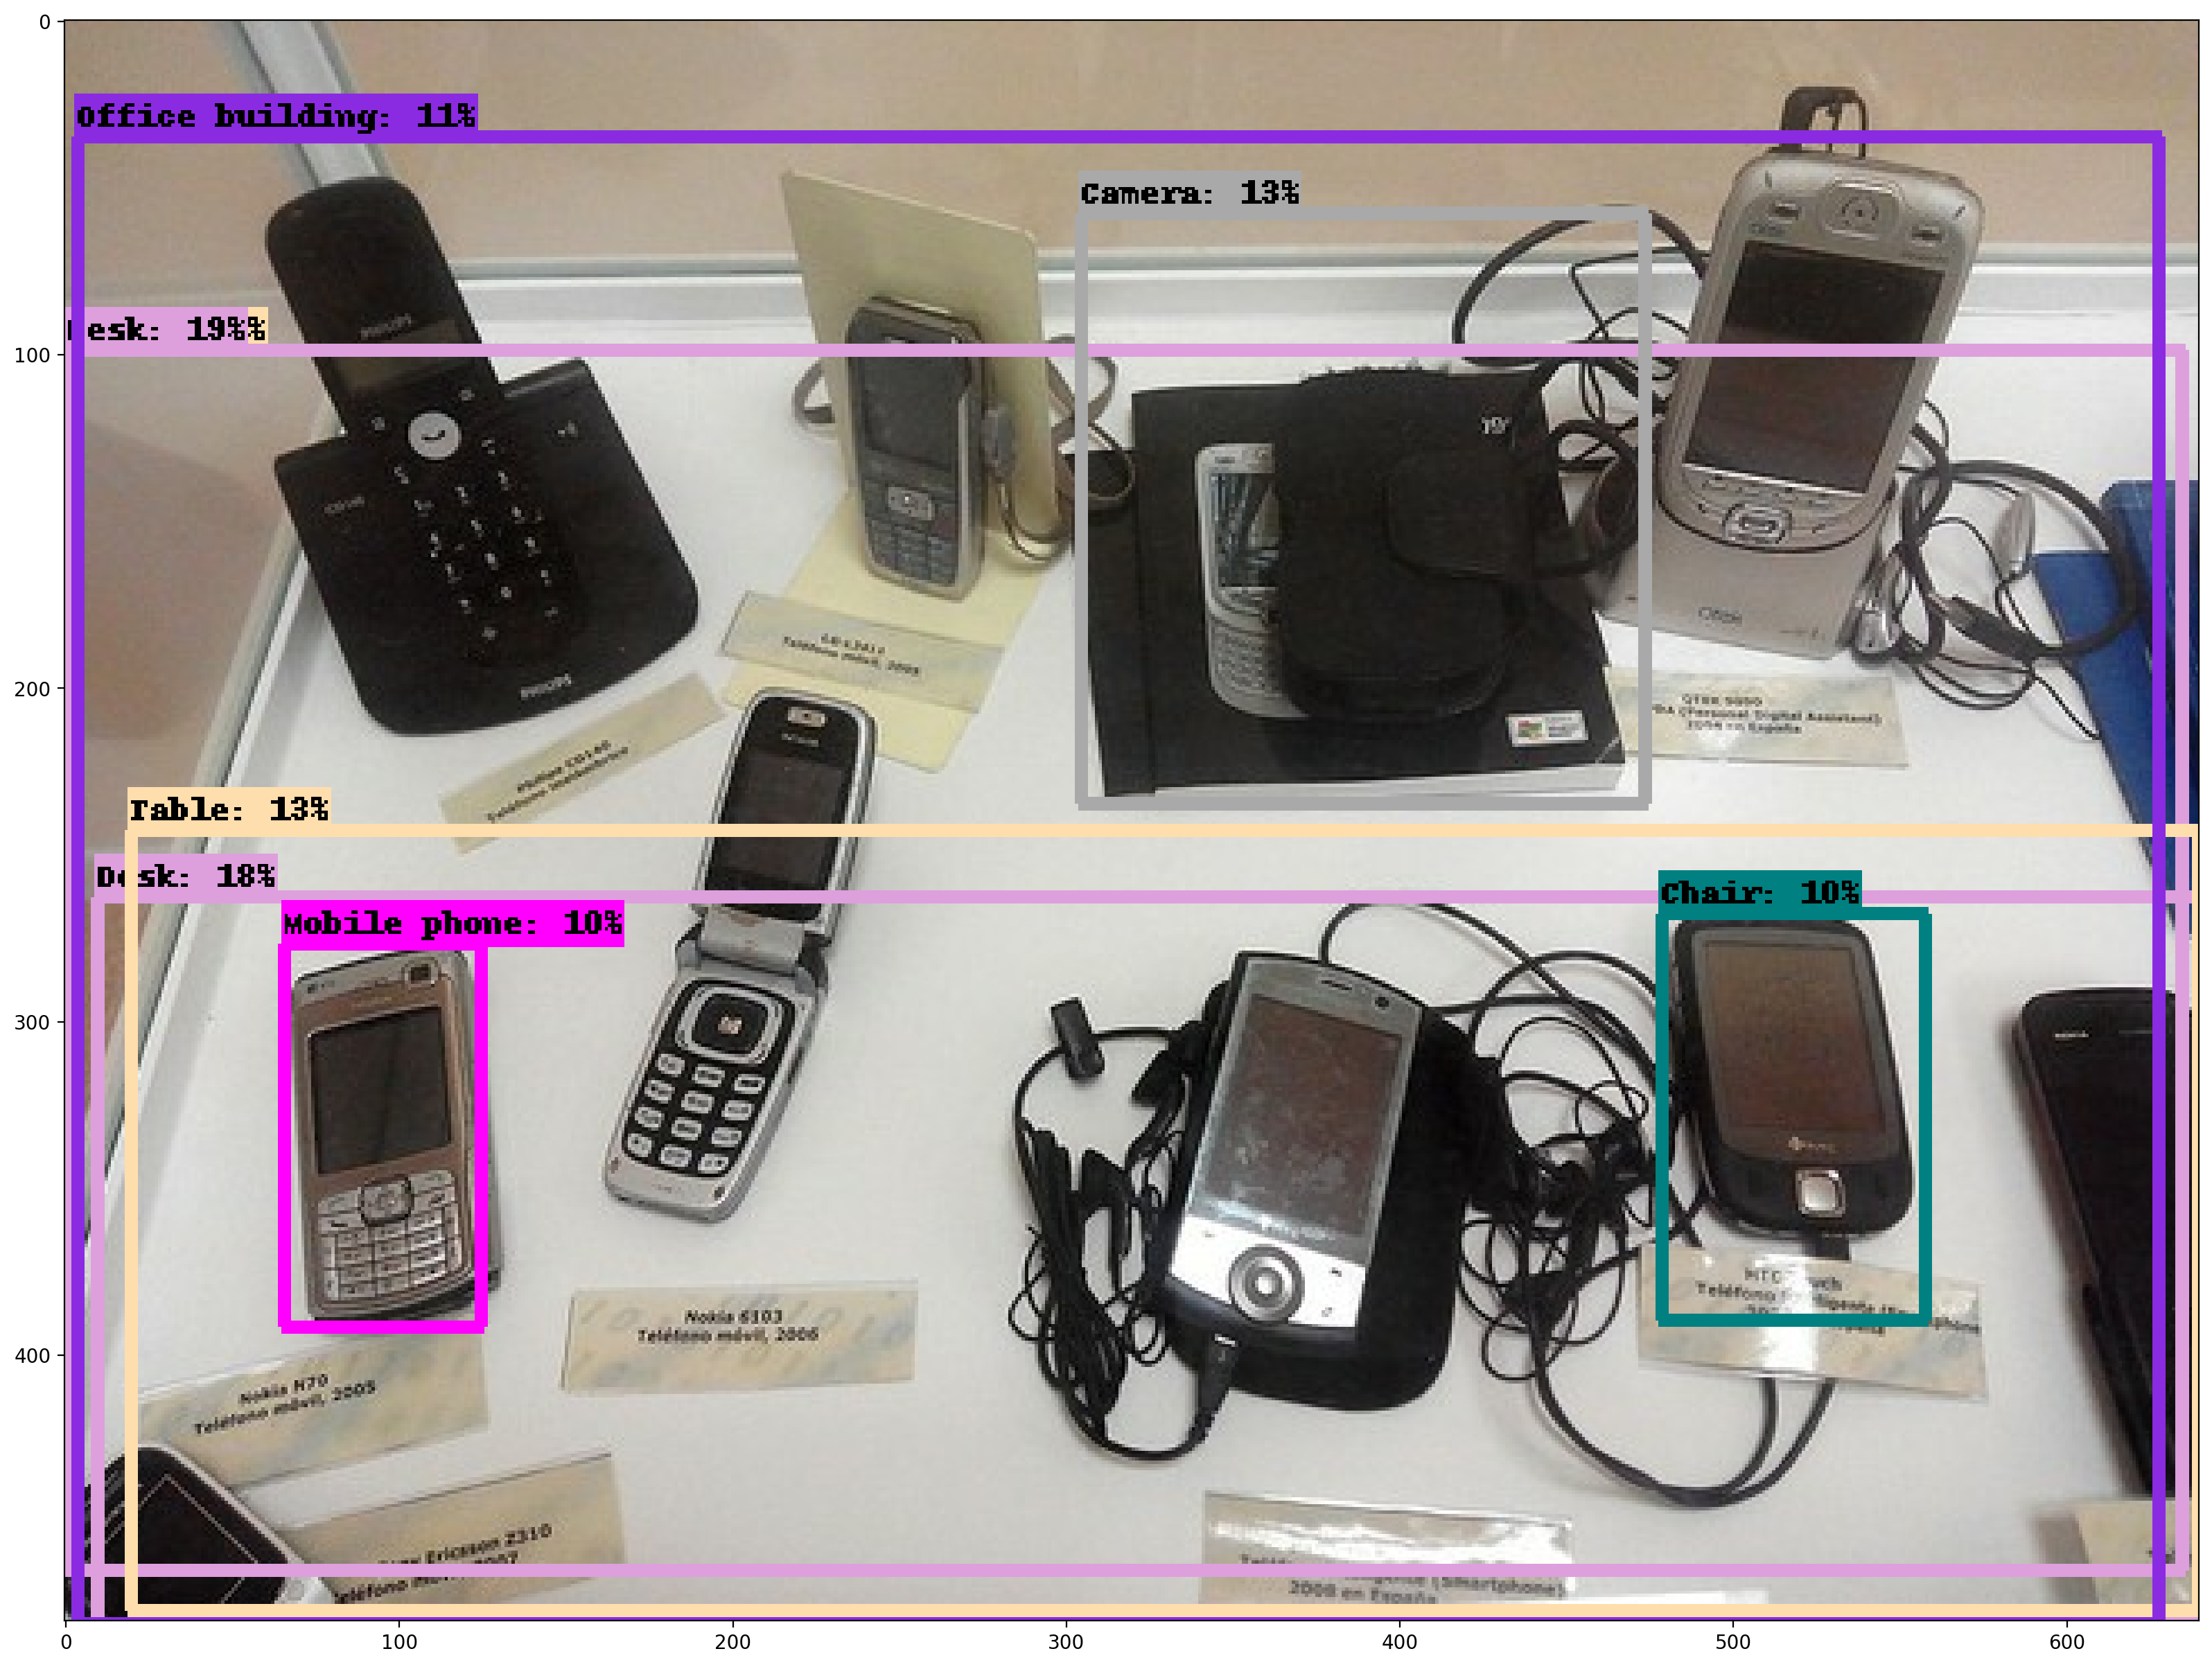

In [10]:
detect_img(image_urls[1])

/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/ipykernel_32109/4241748128.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Image downloaded to /var/folders/xj/g808h2sx0cx0z219xzc0qk7r0000gn/T/tmpo_2qpq9k.jpg.
Found 100 objects.
Inference time:  0.04610085487365723
Font not found, using default font.
Inference time: 0.9024670124053955


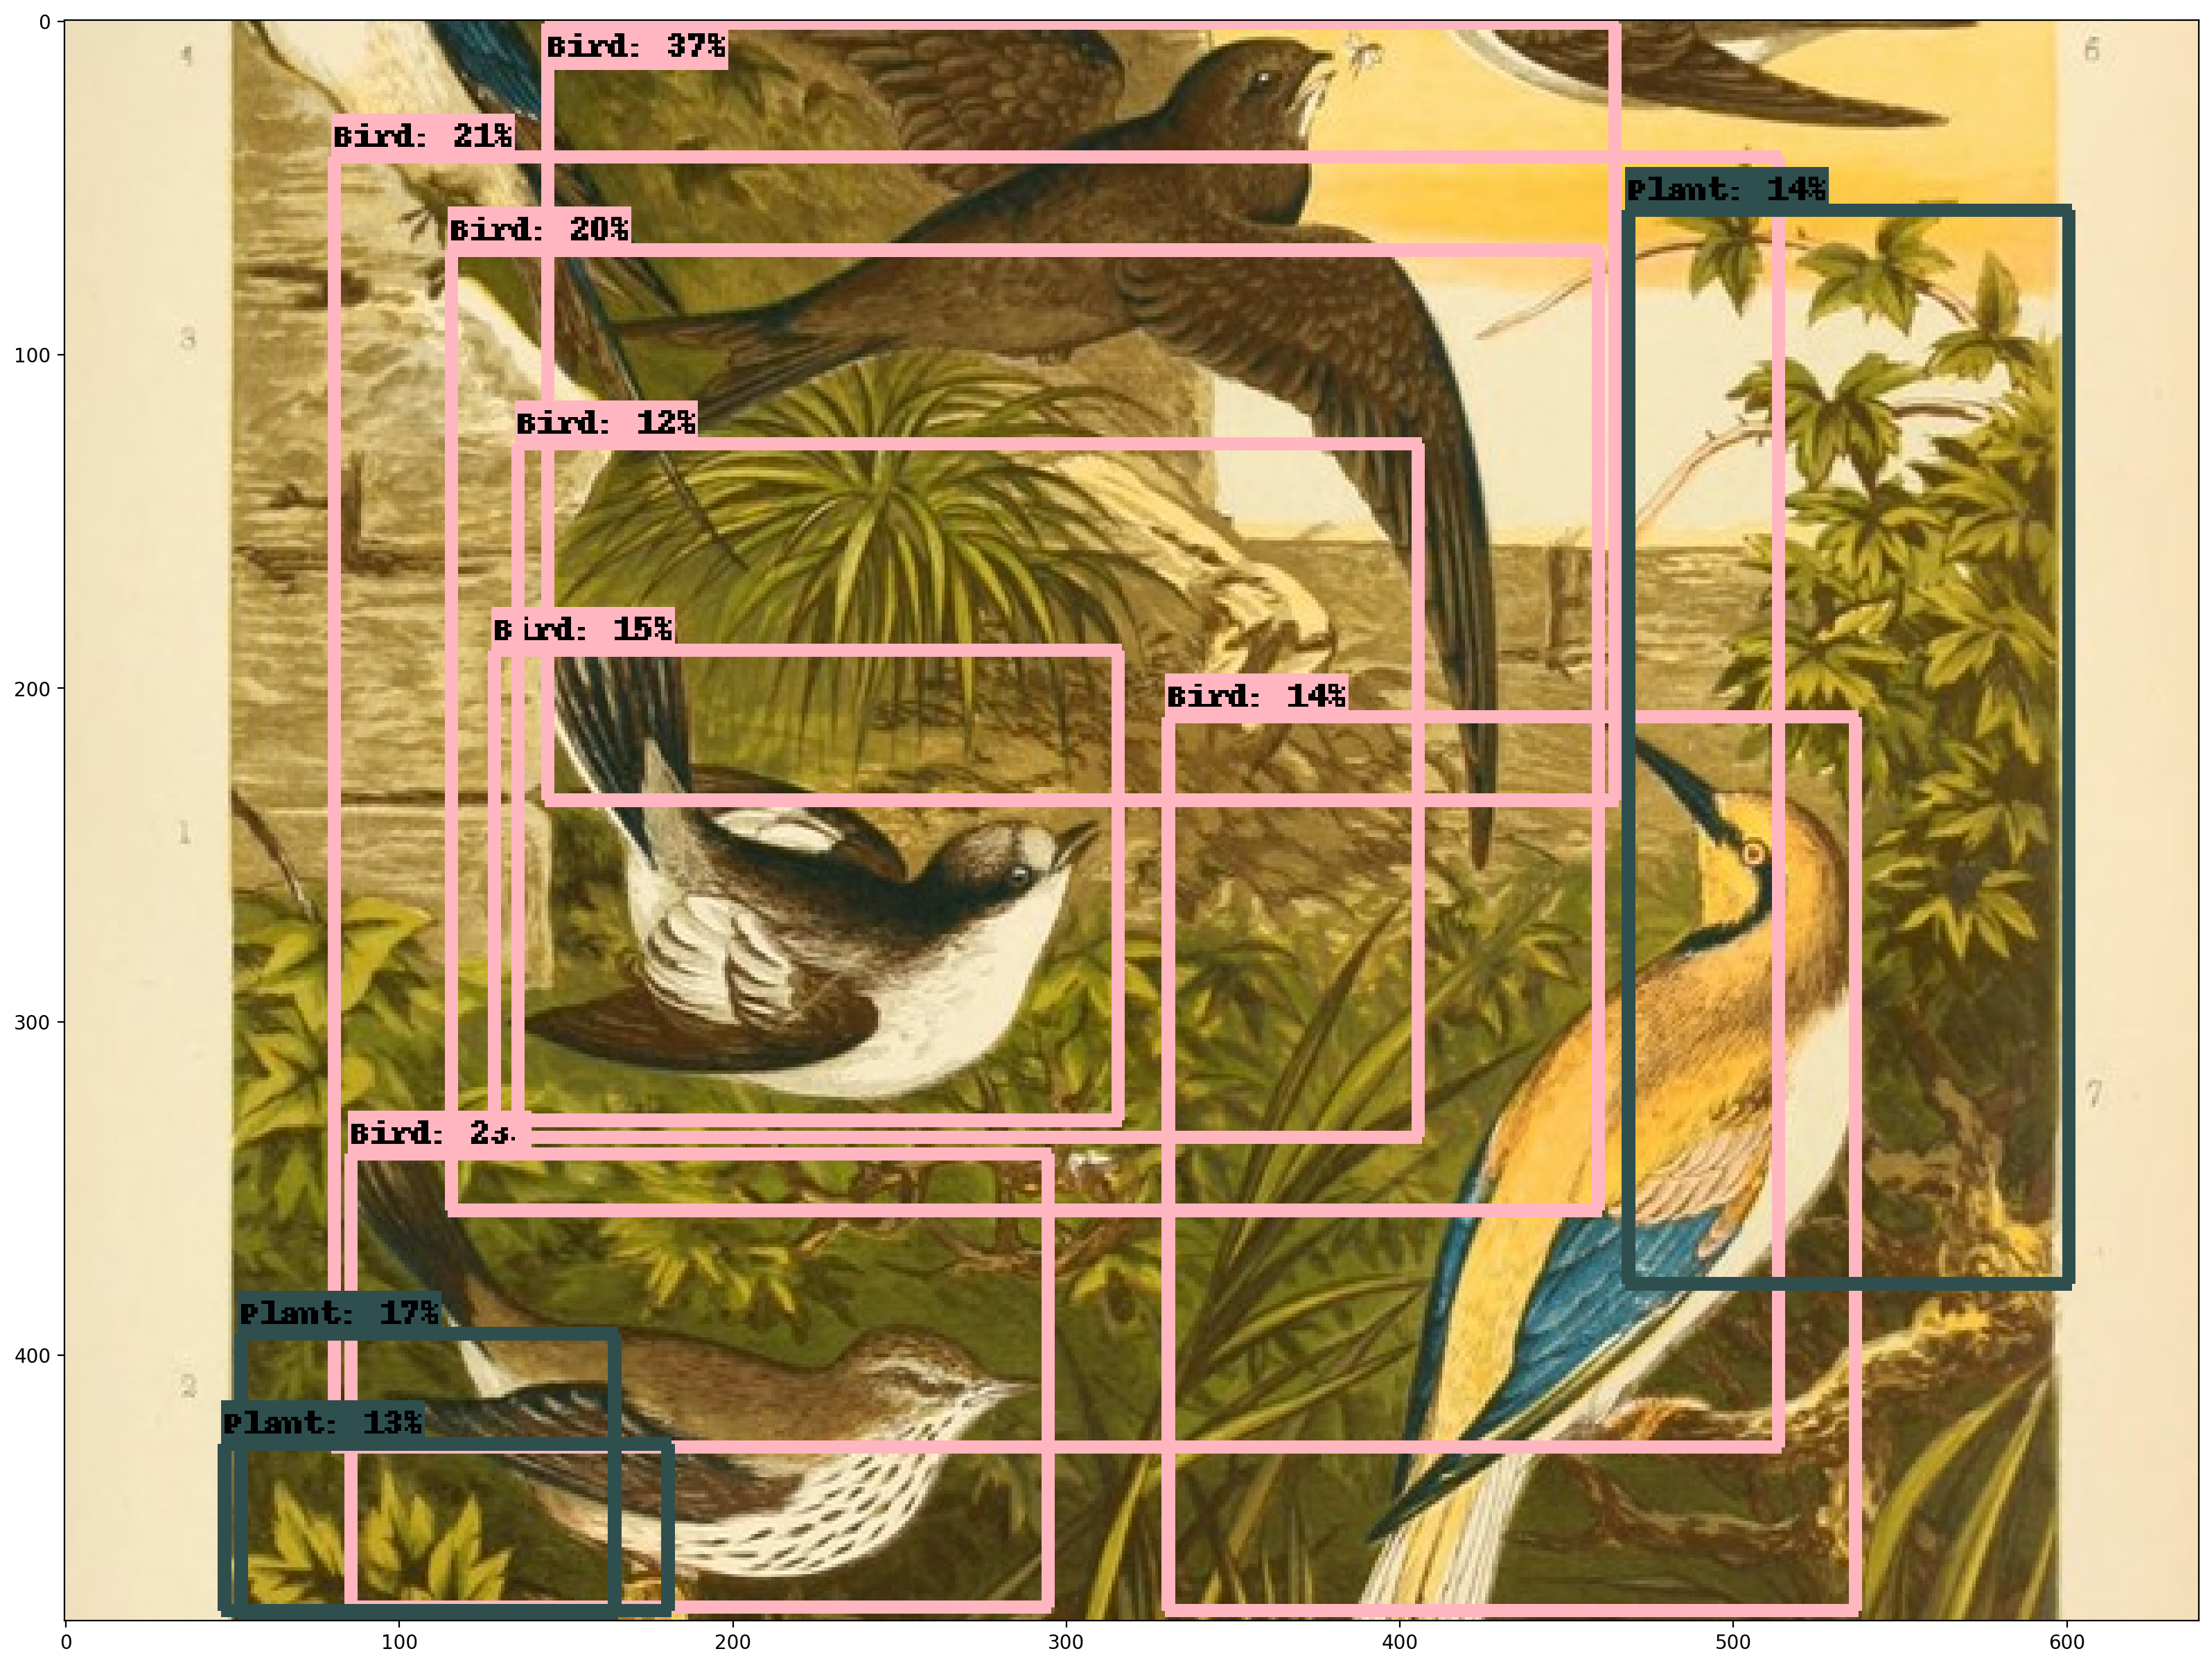

In [11]:
detect_img(image_urls[2])